In [1]:
import os
import sys
sys.path.append(os.path.expandvars('$HOME/software/simple_adl'))
import glob
import yaml
import time
from IPython.core.debugger import set_trace

import numpy as np
import pandas as pd
from pandas import *

import healpy as hp
import fitsio as fits

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from astropy import units as u
from astropy.coordinates import SkyCoord

import simple_adl.survey
import simple_adl.isochrone
from simple_adl.coordinate_tools import distanceModulusToDistance, angsep
from simple_adl.search import write_output, search_by_distance, cut_isochrone_path

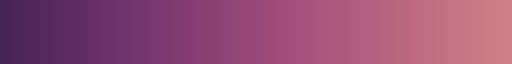

In [2]:
#cmap = sns.cubehelix_palette(start=1.0, rot=-1.0, light=0.8, dark=0.2, hue=1.0, reverse=True, as_cmap=True)
cmap = sns.cubehelix_palette(start=3.0, rot=0.5, light=0.6, dark=0.2, hue=1.0, reverse=True, as_cmap=True)
#cmap = sns.cubehelix_palette(start=0.0, rot=0.0, light=0.7, dark=0.3, hue=1.0, reverse=True, as_cmap=True)
#cmap = sns.cubehelix_palette(start=0.5, rot=0.0, light=0.7, dark=0.3, hue=1.0, reverse=True, as_cmap=True)

cmap

In [3]:
def gnomic(mu_ra, mu_dec, ra, dec):
    """
    https://mathworld.wolfram.com/GnomonicProjection.html
    The Gnomic projection is a conformal (angle-preserving) map of 
    coordinates on a sphere to coordinates on a plane around some central
    coordinate.
    """
    mu_ra = np.deg2rad(mu_ra)
    mu_dec = np.deg2rad(mu_dec)
    ra = np.deg2rad(ra)
    dec = np.deg2rad(dec)
    
    cos_c = np.sin(mu_dec) * np.sin(dec) + np.cos(mu_dec) * np.cos(dec) * np.sin(ra - mu_ra)
    x = np.cos(dec) * np.sin(ra - mu_ra) / cos_c
    y = (np.cos(mu_dec) * np.sin(dec) - np.sin(mu_dec) *np.cos(dec) * np.cos(ra - mu_ra)) / cos_c
    
    return x, y

In [4]:
def plots(position, real_data, sim_data, merged_data, cmap):
    
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
    
    hb = axs[0].hexbin(*gnomic(*position, real_data['ra'], real_data['dec']), mincnt=1, cmap=cmap, gridsize=50)
    cb = fig.colorbar(hb, ax=axs[0])
    # axs[0].scatter(0, 0, c='r', marker='+', s=200)
    axs[0].set_title('DC2 Data')
    axs[0].set_xlabel(r'$x$')
    axs[0].set_ylabel(r'$y$')

    hb = axs[1].hexbin(*gnomic(*position, sim_data['ra'], sim_data['dec']), mincnt=1, cmap=cmap, gridsize=50)
    cb = fig.colorbar(hb, ax=axs[1])
    # axs[1].scatter(0, 0, c='r', marker='+', s=200)
    axs[1].set_title(f'Simulated Satellite {mcid}')
    axs[1].set_xlabel(r'$x$')
    axs[1].set_ylabel(r'$y$')

    hb = axs[2].hexbin(*gnomic(*position, merged_data['ra'], merged_data['dec']), mincnt=1, cmap=cmap, gridsize=50)
    cb = fig.colorbar(hb, ax=axs[2])
    # axs[2].scatter(0, 0, c='r', marker='+', s=200)
    axs[2].set_title('Merged')
    axs[2].set_xlabel(r'$x$')
    axs[2].set_ylabel(r'$y$')

    plot_cmd(merged_data, axs[3])
    plt.show()

In [5]:
def calc_survey(dist,survey='des'):
    if survey == 'des':
        #    Dist   A0     Mv0    logr0
        P0=[[11.3 ,  21.5,   7.8 ,   3.8],
            [22.6 ,  24.1,   8.3 ,   4.2],
            [45.2 ,  17.2,   5.2 ,   4.3], #tuned
            [90.5 ,  8.6 ,   1.2 ,   4.1],
            [181.0,  6.6 ,   -1.1,   4.1],
            [362.0,  6.3 ,   -2.3,   4.3]]
        #P0=[[11.3 ,  23.1 ,  8.1  ,  3.9  ],
        #    [22.6 ,  19.9 ,  7.3  ,  4.1  ],
        #    [45.2 ,  21.1 ,  6.1  ,  4.5  ],
        #    [90.5 ,  8.8  ,  1.2  ,  4.1  ],
        #    [181.0,  7.9  ,  -0.7 ,  4.2  ],
        #    [362.0,  6.4  ,  -2.2 ,  4.3  ]]
    elif survey == 'ps1':
        #    Dist      A0     Mv0    logr0
        P0=[[11.3 ,  21.7,   6.7 ,   3.9],
            [22.6 ,  16.4,   4.3 ,   4.0],
            [45.2 ,  11.5,   1.0 ,   4.0],
            [90.5 ,  8.6 ,   -1.0,   4.0],
            [181.0,  7.2 ,   -2.4,   4.2],
            [362.0,  4.2 ,   -4.8,   4.0]]
        P0=[[11.3 ,  22.8 ,  7.1  ,  4.0],
            [22.6 ,  19.0 ,  5.0  ,  4.1],
            [45.2 ,  14.1 ,  1.8  ,  4.2],
            [90.5 ,  11.0 ,  -0.3 ,  4.3],
            [181.0,  7.5  ,  -2.2 ,  4.2],
            [362.0,  6.8  ,  -4.0 ,  4.4],]


    #A = normalization factor (how curved)
    #B = Mv0 -- the absolute magnitude cut
    #C = R0  -- the r_physical cut
    PARAMS = np.rec.fromrecords(P0,names=['D','A','B','C'])

    a = np.interp(dist,PARAMS['D'],PARAMS['A'])
    b = np.interp(dist,PARAMS['D'],PARAMS['B'])
    c  = np.interp(dist,PARAMS['D'],PARAMS['C'])

    abs_mag = np.linspace(mbins.min(),mbins.max(),1000)
    r_physical = a/(abs_mag - b) + c

    return abs_mag, r_physical, a, b, c

In [6]:
def setdefaults(kwargs,defaults):
    for k,v in defaults.items():
        kwargs.setdefault(k,v)
    return kwargs

In [7]:
def draw_survey(dist,survey,**kwargs):
    defaults = dict(ls='--',color='k',zorder=1)
    kwargs = setdefaults(kwargs,defaults)
    abs_mag, r_physical,a,b,c = calc_survey(dist,survey)
    sel = abs_mag < b
    plt.plot(abs_mag[sel],r_physical[sel],**kwargs)

In [8]:
def query(service, ra, dec, radius=1.0, gmax=23.5):
    """Return data queried from Rubin TAP
    Parameters
    ----------
    service : TAP service [str]
    ra      : Right Ascension [deg]
    dec     : Declination [deg]
    radius  : radius around (ra, dec) [deg]

    Returns
    -------
    good_results : pd.Dataframe
    """

    # Redenning coefficients
    R_g = 3.185
    R_r = 2.140
    R_i = 1.571
    
    # Define our reference position on the sky and cone radius in arcseconds
    # to use in all following examples
    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg
    
    # Quality selection and star--galaxy separation adapted from
    # https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_pandas_stellar_locus.ipynb

    snr_threshold = 5
    mag_err_threshold = 1/snr_threshold
    mag_threshold = 26

    # assuming extendedness is the same in all bands we assume g_extendedness matches extendedness for dp0.2 tables
    
    safe_max_extended = 1.0
    
    query = f"""
        SELECT
            ra, dec,
            mag_g, mag_r,
            magerr_g, magerr_r,
            mag_g - {R_g} AS mag_corrected_g,
            mag_r - {R_r} AS mag_corrected_r,
            extendedness
        FROM dp01_dc2_catalogs.object
        WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND extendedness < {str(safe_max_extended)}
    """

    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    async_results = job.fetch_result()
    results = async_results.to_table().to_pandas()
    job.delete()

    good_snr = (results['magerr_g'] < mag_err_threshold) & (results['magerr_r'] < mag_err_threshold)
    good_results = results[good_snr]
    
    return good_results

In [9]:
def get_catalog_file(catalog_dir, mc_source_id):
    """
    Inputs:
        catalog_dir = string corresponding to directory containing the stellar catalog infiles
        mc_source_id = integer corresponding the target MC_SOURCE_ID value
    Outputs:
        catalog_infile = string corresponding to filename of stellar catalog containing mc_source_id
    """
    catalog_infiles = sorted(glob.glob(catalog_dir + '/*catalog*.fits'))
    mc_source_id_array = []
    catalog_infile_index_array = []
    for ii, catalog_infile in enumerate(catalog_infiles):
        mc_source_id_min = int(os.path.basename(catalog_infile).split('.')[0].split('mc_source_id_')[-1].split('-')[0])
        mc_source_id_max = int(os.path.basename(catalog_infile).split('.')[0].split('mc_source_id_')[-1].split('-')[1])
        assert (mc_source_id_max > mc_source_id_min) & (mc_source_id_min >= 1), 'Found invalue MC_SOURCE_ID values in filenames'
        mc_source_id_array.append(np.arange(mc_source_id_min, mc_source_id_max + 1))
        catalog_infile_index_array.append(np.tile(ii, 1 + (mc_source_id_max - mc_source_id_min)))

    mc_source_id_array = np.concatenate(mc_source_id_array)
    catalog_infile_index_array = np.concatenate(catalog_infile_index_array)

    assert len(mc_source_id_array) == len(np.unique(mc_source_id_array)), 'Found non-unique MC_SOURCE_ID values in filenames'
    assert np.in1d(mc_source_id, mc_source_id_array), 'Requested MC_SOURCE_ID value not among files'
    mc_source_id_index = np.nonzero(mc_source_id == mc_source_id_array)[0][0] # second [0] added by smau 7/23/18 to fix incompatiable type bug
    return catalog_infiles[catalog_infile_index_array[mc_source_id_index]]

In [10]:
def load_sim_data(sim_dir, mc_source_id):
    """
    Load info for injecting satellite sims
    """
    cat_file = get_catalog_file(sim_dir, mc_source_id)
    cat_fits = fits.FITS(cat_file)
    w = cat_fits[1].where(f'MC_SOURCE_ID == {mc_source_id}')
    try:       
        data = cat_fits[1][w]
        cat_fits.close()
        return data
    except IndexError: 
        print('Array is empty')
        
    return

In [11]:
def plot_cmd(data, axs):
    """Plot a color magnitude diagram.
    
    data: DataFrame with photometry data
    """
    y = data['mag_g']  
    x = data['mag_g'] - data['mag_r']
    
    xlims = [-1, 1.5]  #need to find better way to restrict axes
    ylims = [16,28]
    axs.set_xlim(xlims); 
    axs.set_ylim(ylims); 
    
    axs.set_ylabel('$Magnitude (g)$')
    axs.set_xlabel('$Color (g-r)$')
    
    axs.plot(x, y, 'ko', markersize=0.3, alpha=0.3)
    axs.invert_yaxis()

    
    plt.show()
    
    return

In [12]:
# Note that this query (which uses the truth information about star--galaxy separation) is much slower
def query_RSP_truth(service, ra, dec, radius=1):
    # Define our reference position on the sky and cone radius in arcseconds
    # to use in all following examples
    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg

    query = f"""
        SELECT
            obj.ra, obj.dec,
            obj.mag_g, obj.mag_r,
            obj.magerr_g, obj.magerr_r,
            obj.mag_g as mag_corrected_g, obj.mag_r as mag_corrected_r,
            obj.extendedness as extended_class
        FROM dp01_dc2_catalogs.object as obj
        JOIN dp01_dc2_catalogs.truth_match as truth
        ON truth.match_objectId = obj.objectId
        WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND obj.extendedness < 1
        AND truth.match_objectId >= 0 
        AND truth.is_good_match = 1
        AND truth.truth_type = 2
    """
    
    df = service.search(query).to_table().to_pandas()
    df['MC_SOURCE_ID'] = 0
    
    return df

In [13]:
from lsst.rsp import get_tap_service

service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

NameError: name 'sims' is not defined

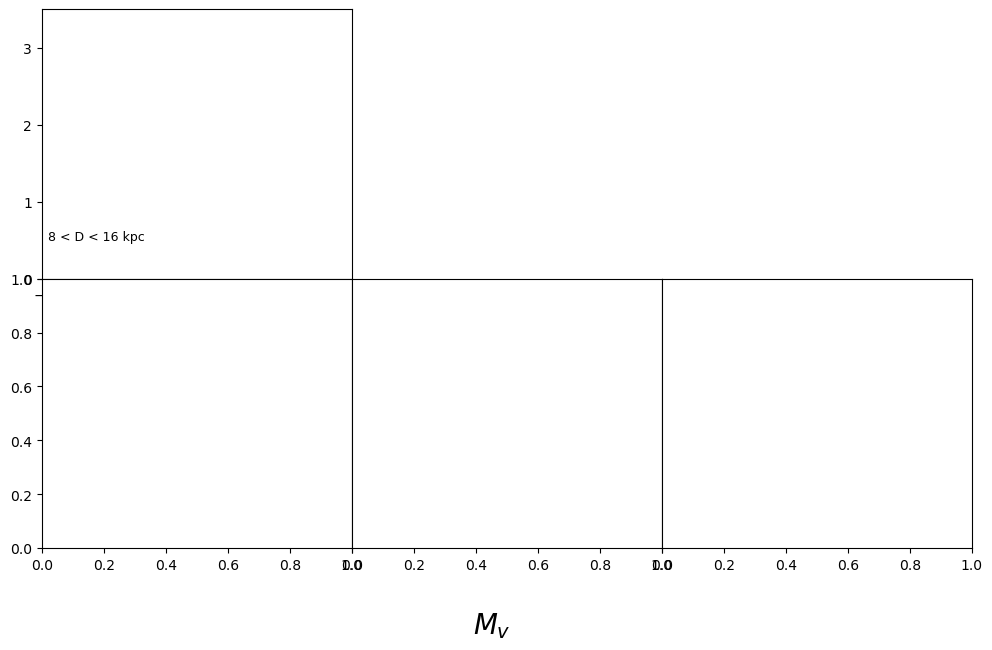

In [14]:
# bins in distance
dbins = 2**np.arange(3,10)
# bins in absolute magnitude
mbins = np.arange(-11,2.5,0.75)
# bins in physical radius
rbins = np.arange(0,3.75,0.35)

fig,axes = plt.subplots(2,3,figsize=(12,7))
plt.subplots_adjust(wspace=0, hspace=0)
axes[0,1].axis('off')
axes[0,2].axis('off')
axes[1,2].axes.get_yaxis().set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
fig.text(0.5, 0, '$ M_{v} $', ha='center', va='center', fontsize=20)

for i,(dmin,dmax) in enumerate(zip(dbins[:-1],dbins[1:])):
    plt.sca(axes.flat[i])
    plt.text(-10, 0.5, "%i < D < %i kpc"%(dmin,dmax), fontsize=9, )
    plt.xlim(-10.25,1.75)
    plt.ylim(0, 3.5)
    plt.yticks(np.arange(0, 4, 1))
    s = sims[(sims['DISTANCE'] >= dmin)&(sims['DISTANCE'] < dmax)]

    det = s["SIG"] > 9

    total = np.histogram2d(s['ABS_MAG'],np.log10(s['R_PHYSICAL']*1e3),
                       bins=[mbins,rbins])[0]
    ndet = np.histogram2d(s['ABS_MAG'],np.log10(s['R_PHYSICAL']*1e3),
                       weights=det,bins=[mbins,rbins])[0]

    pdet = ndet.astype(float)/total
    im = plt.pcolormesh(mbins,rbins,pdet.T,rasterized=True)
    draw_survey(np.sqrt(dmin*dmax), survey='des')

cb = fig.colorbar(im, ax=axes.ravel().tolist(), label='Detection Efficiency')

In [1]:
def plot_cmd_sep(rdata, sdata, axs):
    """Plot a color magnitude diagram.
    
    data: merged_data DataFrame with photometry data
    """
    y = rdata['mag_g']  
    x = rdata['mag_g'] - rdata['mag_r']
    
    xlims = [-1, 1.5]  #need to find better way to restrict axes
    ylims = [16,28]
    axs.set_xlim(xlims); 
    axs.set_ylim(ylims); 
    
    axs.set_ylabel('$Magnitude (g)$')
    axs.set_xlabel('$Color (g-r)$')
    
    axs.plot(x, y, 'ko', markersize=0.3, alpha=0.3)
    y = sdata['mag_g']  
    x = sdata['mag_g'] - sdata['mag_r']
    axs.plot(x, y, 'ro', markersize=0.3, alpha=0.3)
    axs.invert_yaxis()

    
    plt.show()
    
    return


In [32]:
pd.set_option("display.max_columns", None)

In [15]:
sim_dir = '/project/shared/data/satsim/lsst_dc2_v7'
population_file = glob.glob(os.path.join(sim_dir, '*population*')) 
sim_pop = fits.read(population_file[0])
sim_pop = sim_pop.byteswap().newbyteorder() 
df1 = pd.DataFrame(sim_pop)
file_ids = [files[30:45] for files in glob.glob('results_dir/imperfect/*.csv')]


for i,f in enumerate(population_file):
    if i == 0:
        continue
    for ids in file_ids:
        if ids in f:
            sim_pop = fits.read(f)
            sim_pop = sim_pop.byteswap().newbyteorder()
            df2 = pd.DataFrame(sim_pop)
            df1 = pd.concat((df1,df2), ignore_index=True)
            break#creates dataframe from the array
            
sim_data_v7 = df1
sim_data_v7 = sim_data_v7.assign(version=[7]*len(sim_data_v7))

sim_dir = '/project/shared/data/satsim/lsst_dc2_v6'
population_file = glob.glob(os.path.join(sim_dir, '*population*')) 
sim_pop = fits.read(population_file[0])
sim_pop = sim_pop.byteswap().newbyteorder() 
df1 = pd.DataFrame(sim_pop)

for i,f in enumerate(population_file):
    if i == 0:
        continue
    for ids in file_ids:
        if ids in f:
            sim_pop = fits.read(f)
            sim_pop = sim_pop.byteswap().newbyteorder()
            df2 = pd.DataFrame(sim_pop)
            df1 = pd.concat((df1,df2), ignore_index=True)
            break#creates dataframe from the array
            
sim_data_v6 = df1
sim_data_v6 = sim_data_v6.assign(version=[6]*len(sim_data_v6))

In [46]:
v7_sample['MC_SOURCE_ID'].values

array([8308, 8397, 8251, 6564, 6460, 6489, 3864, 7085, 7097, 4807, 2524,
       2548, 2557, 9792, 4414, 4012, 1102, 1154,  338, 5523, 5567, 5568,
       5569, 4113, 4175, 7369, 7456, 7462, 7468, 7476,  439, 6356, 6396,
       3304, 3355, 4650, 8612, 5285, 6817, 6858, 6881, 2643,   16,   35,
         94,  517,  561, 3108, 3141, 7202, 7212, 7226, 7228, 7260, 7269,
       7284, 3917, 3939, 6946, 6999, 1934, 1981, 9824, 9870, 9877, 9878,
       9615, 9623, 9627, 9652, 9661, 9223, 9262, 3663, 2110, 2137, 2140,
       2153, 2171, 4725, 4736, 7676, 2911, 2935, 2940, 2995, 7703, 7753,
       7768, 7780, 6223, 9427, 9483, 9489, 9492, 3285, 5618, 1379, 1395,
       5008, 5011, 5062, 2223, 2225, 2244, 2265, 2066, 9336, 9375, 1820,
       1824, 1853, 5304, 5395, 4543, 2809, 2826, 2844, 2857, 1534, 1575,
       1589, 6605, 6644, 6658, 8183, 8185, 4910, 4917, 4979, 4997, 7140,
       7153, 9023, 9065, 2716, 2753, 2787, 2789,  254,  270,  293, 5769,
       6749, 1604, 8004, 8005, 8031, 8071, 2319, 24

In [22]:
import importlib
importlib.reload(simple_adl.survey)

<module 'simple_adl.survey' from '/home/kabelo-t/software/simple_adl/simple_adl/survey.py'>

In [24]:
_data_cache = None

Querying region (61.22122, -43.9574)
Satellites at  (61.22122, -43.9574) :
 [2171]


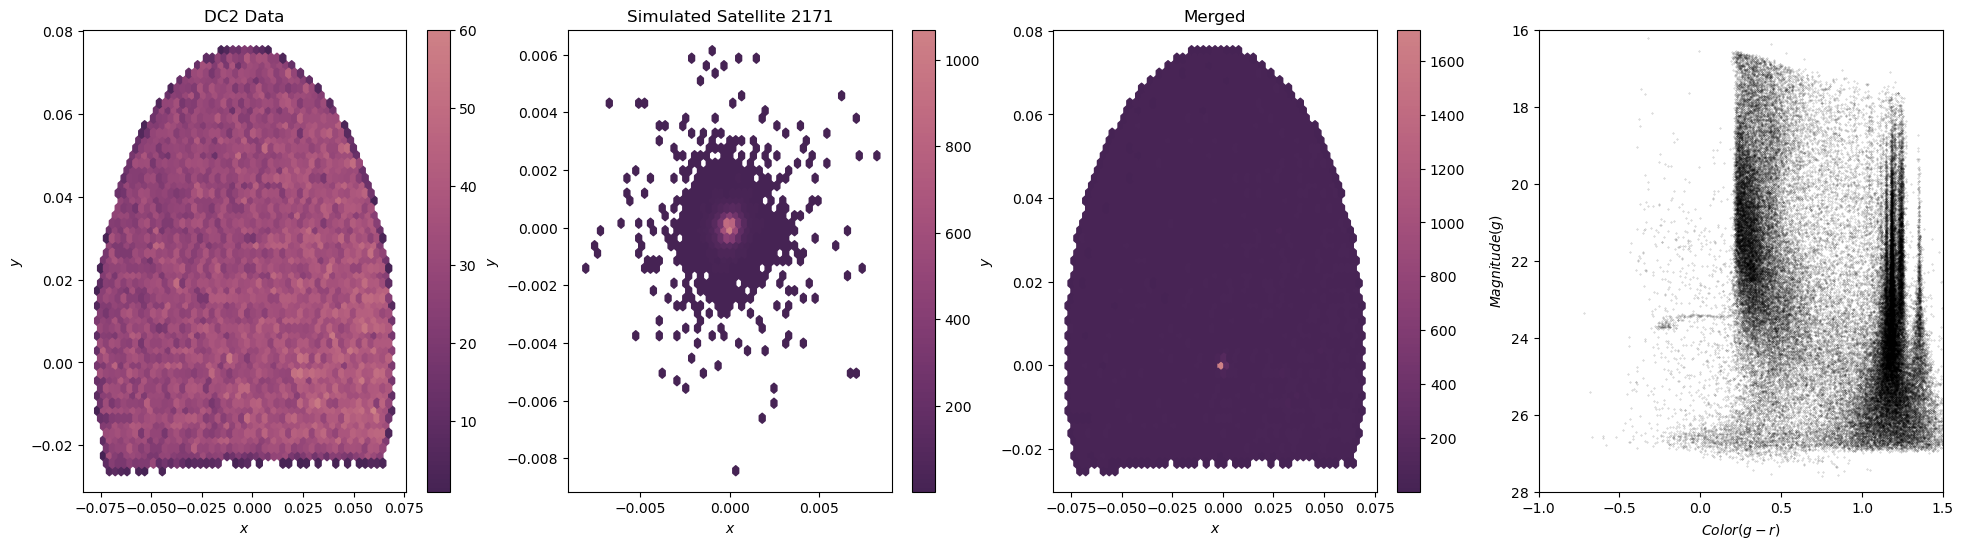

Searching for: MC_SOURCE_ID  2171
Characteristic density = 400.0 deg^-2


/home/kabelo-t/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):


Fitting aperture to hotspot...
Characteristic density local = 400.0 deg^-2 = 0.111 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -0.585, r_peak:        0.010, sig:        4.279, ra_peak:       60.372, dec_peak:      -44.539
> /home/kabelo-t/software/simple_adl/simple_adl/survey.py(437)fit_aperture()
    435         set_trace()
    436 
--> 437         return ra_peak_array, dec_peak_array, r_peak_array, sig_peak_array, n_obs_peak_array, n_obs_half_peak_array, n_model_peak_array
    438 
    439     def plot_cmd(self, iso_sel):



ipdb>  self.plot_cmd(iso_sel)


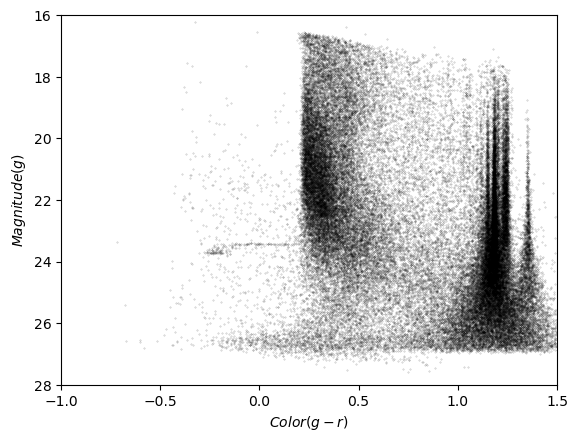

ipdb>  q


In [25]:
sim_dir = '/project/shared/data/satsim/lsst_dc2_v7'
population_file = '/project/shared/data/satsim/lsst_dc2_v7/sim_population_lsst_dc2_v7_mc_source_id_0002101-0002200.fits'

with open('config.yaml') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.SafeLoader)
    survey = simple_adl.survey.Survey(cfg)

sim_population = fits.read(population_file)
sim_population  = sim_population.byteswap().newbyteorder()    # resetting byte order for compatibility
sim_population = sim_population[sim_population['FRACDET_CORE'] == 1]
sim_population = sim_population[sim_population['FRACDET_WIDE'] == 1]
sim_population = sim_population[sim_population['FRACDET_HALF'] == 1]
sim_population = sim_population[sim_population['MC_SOURCE_ID'] == 2171]
sim_positions = np.unique(sim_population[['RA', 'DEC']])
radius = 2

for iii,position in enumerate(sim_positions):
    sim_population_at_position = sim_population[sim_population[['RA', 'DEC']] == position]
    t = pd.DataFrame(sim_population_at_position)
    if len(t['MC_SOURCE_ID'].values) == 0:
        print(f'No sims at {position}')
        continue
    print(f'Querying region {position}')
    if _data_cache is not None:
        real_data = _data_cache
    else:
        real_data = query_RSP_truth(service, position[0], position[1], radius)  # pd.DataFrame
        _data_cache = real_data
    print('Satellites at ', position, ':\n', t['MC_SOURCE_ID'].values)
    for mcid in sim_population['MC_SOURCE_ID']:
        sim_data = load_sim_data(sim_dir, mcid)
        if sim_data is not None:
            sim_data = sim_data.byteswap().newbyteorder()   # resetting byte order for compatibility
            sim_data = pd.DataFrame(sim_data)               # convert to pd.DataFrame
            # mask to ensure we only use sims within the queried data's footprint

            c2 = SkyCoord(sim_data['ra'], sim_data['dec'], unit='deg', frame='icrs')
            center = SkyCoord(position[0], position[1], unit='deg')
            d2d = center.separation(c2) 
            catalogmsk = d2d < radius*u.deg
            sim_data = sim_data[catalogmsk]

            if sim_data.empty:
                print(f'No sim data to inject into region at ({position[0]},{position[1]}) after applying mask')
                continue

            # merging the sims and dc2 data
            frames = [real_data[real_data.columns[:-1]], sim_data[real_data.columns[:-1]]]
            merged_data = pd.concat(frames)  # pd.Dataframe
            # perform mag cut on the merged data
            good_snr = (merged_data['magerr_g'] < 0.2) & (merged_data['magerr_r'] < 0.2)
            merged_data = merged_data[good_snr]

            fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

            hb = axs[0].hexbin(*gnomic(*position, real_data['ra'], real_data['dec']), mincnt=1, cmap=cmap, gridsize=50)
            cb = fig.colorbar(hb, ax=axs[0])
            # axs[0].scatter(0, 0, c='r', marker='+', s=200)
            axs[0].set_title('DC2 Data')
            axs[0].set_xlabel(r'$x$')
            axs[0].set_ylabel(r'$y$')

            hb = axs[1].hexbin(*gnomic(*position, sim_data['ra'], sim_data['dec']), mincnt=1, cmap=cmap, gridsize=50)
            cb = fig.colorbar(hb, ax=axs[1])
            # axs[1].scatter(0, 0, c='r', marker='+', s=200)
            axs[1].set_title(f'Simulated Satellite {mcid}')
            axs[1].set_xlabel(r'$x$')
            axs[1].set_ylabel(r'$y$')

            hb = axs[2].hexbin(*gnomic(*position, merged_data['ra'], merged_data['dec']), mincnt=1, cmap=cmap, gridsize=50)
            cb = fig.colorbar(hb, ax=axs[2])
            # axs[2].scatter(0, 0, c='r', marker='+', s=200)
            axs[2].set_title('Merged')
            axs[2].set_xlabel(r'$x$')
            axs[2].set_ylabel(r'$y$')

            plot_cmd(merged_data, axs[3])
            plt.show()

            print('Searching for: MC_SOURCE_ID ', mcid)

            ra = position[0]
            dec = position[1]
            region = simple_adl.survey.Region(survey, ra, dec)
            region.data = merged_data

            # Scan in distance moduli    
            distance_modulus = t.loc[t['MC_SOURCE_ID'] == mcid]['DISTANCE_MODULUS']
            distance_modulus = distance_modulus.values[0]
            iso_search = simple_adl.isochrone.Isochrone(survey=survey.isochrone['survey'],
                                                   band_1=survey.band_1.lower(),
                                                   band_2=survey.band_2.lower(),
                                                   age=12.0, #survey.isochrone['age'],
                                                   metallicity=0.00010, #survey.isochrone['metallicity'],
                                                   distance_modulus=distance_modulus)
            iso_selection = cut_isochrone_path(region.data[survey.mag_dered_1], 
                                                  region.data[survey.mag_dered_2],
                                                  region.data[survey.mag_err_1],
                                                  region.data[survey.mag_err_2],
                                                  iso_search,
                                                  survey.catalog['mag_max'],
                                                  radius=0.1)

            results = search_by_distance(survey, region, distance_modulus, iso_selection) 
            ra_peak_array, dec_peak_array, r_peak_array, sig_peak_array, distance_modulus_array, n_obs_peak_array, n_obs_half_peak_array, n_model_peak_array = np.asarray(results)
            best_ra_peak, best_dec_peak, best_r_peak, best_distance_modulus, n_obs_peak, n_obs_half_peak, n_model_peak, best_sig_peak = 0, 0, 0, 0, 0, 0, 0, 0

            if mcid: 
                mc_source_id_array = np.full_like(distance_modulus_array, mcid)
            else:
                mc_source_id_array = np.zeros(len(distance_modulus_array))

            # Sort peaks according to significance
            index_sort = np.argsort(sig_peak_array)[::-1]
            ra_peak_array = ra_peak_array[index_sort]
            dec_peak_array = dec_peak_array[index_sort]
            r_peak_array = r_peak_array[index_sort]
            sig_peak_array = sig_peak_array[index_sort]
            distance_modulus_array = distance_modulus_array[index_sort]
            n_obs_peak_array = n_obs_peak_array[index_sort]
            n_obs_half_peak_array = n_obs_half_peak_array[index_sort]
            n_model_peak_array = n_model_peak_array[index_sort]
            mc_source_id_array = mc_source_id_array[index_sort]

            # Collect overlapping peaks
            for ii in range(0, len(sig_peak_array)):
                if sig_peak_array[ii] < 0:
                    continue
                sep = angsep(ra_peak_array[ii], dec_peak_array[ii], ra_peak_array, dec_peak_array)
                sig_peak_array[(sep < r_peak_array[ii]) & (np.arange(len(sig_peak_array)) > ii)] = -1.

            # Prune the list of peaks
            ra_peak_array = ra_peak_array[sig_peak_array > 0.]
            dec_peak_array = dec_peak_array[sig_peak_array > 0.]
            r_peak_array = r_peak_array[sig_peak_array > 0.]
            distance_modulus_array = distance_modulus_array[sig_peak_array > 0.]
            n_obs_peak_array = n_obs_peak_array[sig_peak_array > 0.]
            n_obs_half_peak_array = n_obs_half_peak_array[sig_peak_array > 0.]
            n_model_peak_array = n_model_peak_array[sig_peak_array > 0.]
            mc_source_id_array = mc_source_id_array[sig_peak_array > 0.]
            sig_peak_array = sig_peak_array[sig_peak_array > 0.] # Update the sig_peak_array last!

            if sig_peak_array[0] > best_sig_peak:
                best_sig_peak = sig_peak_array[0]
                best_ra_peak = ra_peak_array[0]
                best_dec_peak = dec_peak_array[0]
                best_r_peak = r_peak_array[0]
                best_distance_modulus = distance_modulus_array[0]
                n_obs_peak = n_obs_peak_array[0]
                n_obs_half_peak = n_obs_half_peak_array[0]
                n_model_peak = n_model_peak_array[0]
                mc_source_id = mc_source_id_array[0]

            del merged_data

            print('\n---------------------------------')
            for ii in range(0, len(sig_peak_array)):
                print('{:0.2f} sigma; (RA, Dec) = ({:0.2f}, {:0.2f}); r = {:0.2f} deg; d = {:0.1f}, mu = {:0.2f} mag, mc_source_id: {:0.2f}'.format(sig_peak_array[ii], 
                         ra_peak_array[ii], 
                         dec_peak_array[ii], 
                         r_peak_array[ii],
                         distanceModulusToDistance(distance_modulus_array[ii]),
                         distance_modulus_array[ii],
                         mc_source_id_array[ii]))  

            if best_sig_peak <= 9:
                print(f'--> {mcid} NOT FOUND')
            else:   
                print(f'--> {mcid} FOUND')

In [35]:
df3

,SIG,RA,DEC,MODULUS,R,N_OBS,N_OBS_HALF,N_MODEL,MC_SOURCE_ID
0,5.61,53.52,-36.19,19.79,0.29,262.0,80.0,181.87,1221.0
1,11.16,53.42,-36.26,14.95,0.02,28.0,19.0,1.26,1223.0
2,5.83,53.27,-36.26,15.40,0.28,445.0,126.0,333.69,1224.0
3,5.40,53.49,-36.32,22.16,0.18,96.0,27.0,52.85,1225.0
4,37.50,53.42,-36.27,16.02,0.01,423.0,97.0,29.15,1226.0
5,37.50,53.41,-36.27,20.29,0.04,324.0,85.0,4.34,1227.0
6,37.50,53.41,-36.26,21.41,0.01,162.0,15.0,0.17,1229.0
7,4.56,52.76,-36.43,13.88,0.02,9.0,4.0,1.42,1230.0
8,3.73,63.20,-36.90,19.40,0.05,16.0,4.0,5.69,1251.0
9,37.50,63.40,-35.27,20.08,0.01,162.0,62.0,0.22,1253.0


In [52]:
#setting up sim dataframe
sim_dir = '/project/shared/data/satsim/lsst_dc2_v6'
population_file = glob.glob(os.path.join(sim_dir, '*population*'))

files = glob.glob("results_dir/perfect/*.csv")
first_file = files[0]
sim_pop = fits.read(population_file[0])
sim_pop = sim_pop.byteswap().newbyteorder() 
df1 = pd.DataFrame(sim_pop)
file_ids = [files[8:23] for files in os.listdir('results_dir/perfect') if 'ipynb' not in files]


for i,f in enumerate(population_file):
    if i == 0:
        continue
    for ids in file_ids:
        if ids in f:
            sim_pop = fits.read(f)
            sim_pop = sim_pop.byteswap().newbyteorder()
            df2 = pd.DataFrame(sim_pop)
            df1 = pd.concat((df1,df2), ignore_index=True)
            break
            
datadf = read_csv(first_file)
for f in files:
    if f == first_file:
        continue
    df3 = pd.read_csv(f)
    datadf = pd.concat((datadf, df3), ignore_index=True)
    
mask = []
for mcid in df1['MC_SOURCE_ID'].values:
    mask.append(mcid in datadf['MC_SOURCE_ID'].values)

v6 = df1[mask]
v6 = pd.merge(v6,datadf[['MC_SOURCE_ID','SIG', 'N_MODEL','N_OBS']],on='MC_SOURCE_ID',how='left')         #merge
v6 = v6[v6['FRACDET_CORE'] == 1]
v6 = v6[v6['FRACDET_WIDE'] == 1]
v6 = v6[v6['FRACDET_HALF'] == 1]
v6 = v6[v6['EXTENSION'] <= 0.05]
v6.loc[v6.DIFFICULTY == 2, 'SIG'] = 37.5

In [26]:
#setting up sim dataframe
sim_dir = '/project/shared/data/satsim/lsst_dc2_v7'      #perfect star/galaxy separation
population_file = glob.glob(os.path.join(sim_dir, '*population*'))

files = glob.glob("results_dir/perfect/*.csv")
first_file = files[0]
sim_pop = fits.read(population_file[0])
sim_pop = sim_pop.byteswap().newbyteorder() 
df1 = pd.DataFrame(sim_pop)
file_ids = [files[8:23] for files in os.listdir('results_dir/perfect') if 'ipynb' not in files]


for i,f in enumerate(population_file):
    if i == 0:
        continue
    for ids in file_ids:
        if ids in f:
            sim_pop = fits.read(f)
            sim_pop = sim_pop.byteswap().newbyteorder()
            df2 = pd.DataFrame(sim_pop)
            df1 = pd.concat((df1,df2), ignore_index=True)
            break
            
datadf = read_csv(first_file)
for f in files:
    if f == first_file:
        continue
    df3 = pd.read_csv(f)
    datadf = pd.concat((datadf, df3), ignore_index=True)
    
v7 = pd.merge(df1,datadf[['MC_SOURCE_ID','SIG']],on='MC_SOURCE_ID',how='left')         #merge
v7 = v7[v7['FRACDET_CORE'] == 1]
v7 = v7[v7['FRACDET_WIDE'] == 1]
v7 = v7[v7['FRACDET_HALF'] == 1]
v7 = v7[v7['EXTENSION'] <= 0.05]
v7.loc[v7.DIFFICULTY == 2, 'SIG'] = 37.5

In [28]:
mask = []
dummy = pd.DataFrame()
for mcid in v6['MC_SOURCE_ID']:
    mask.append(mcid in v7['MC_SOURCE_ID'].values)
    
v6 = v6[mask]

In [29]:
count = 0
mask = []
for mcid in v7['MC_SOURCE_ID']:
    mask.append(mcid in v6['MC_SOURCE_ID'].values)
    
v7 = v7[mask]

In [29]:
rcat = v7['N_CATALOG'].values/v6['N_CATALOG'].values
robs = v7['N_OBS'].values/v6['N_OBS'].values
rmodel = v7['N_MODEL'].values/v6['N_MODEL'].values

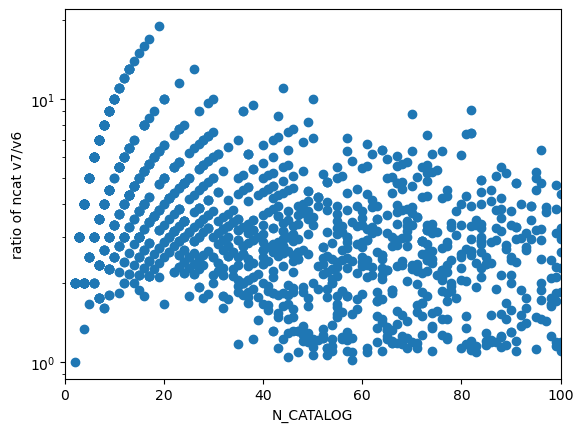

In [44]:
fig, axs = plt.subplots(1,1)
axs.set_xlabel('N_CATALOG')
axs.set_ylabel('ratio of ncat v7/v6')
axs.set_xlim(left=0, right=100)
axs.set_yscale('log')
axs.scatter(v7['N_CATALOG'].values,rcat)

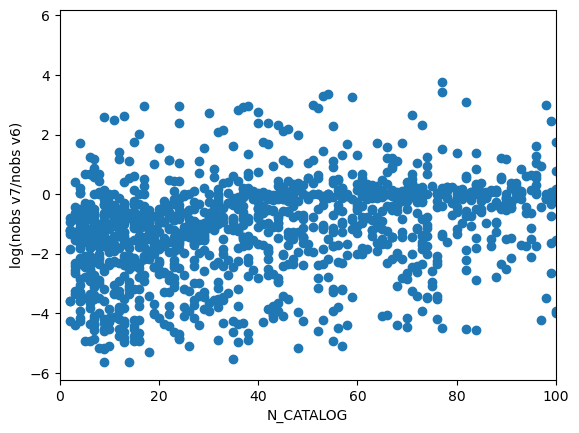

In [38]:
fig, axs = plt.subplots(1,1)
axs.set_xlabel('N_CATALOG')
axs.set_xlim(left=0, right=100)
axs.set_ylabel('log(nobs v7/nobs v6)')
axs.scatter(v7['N_CATALOG'].values, np.log(robs))

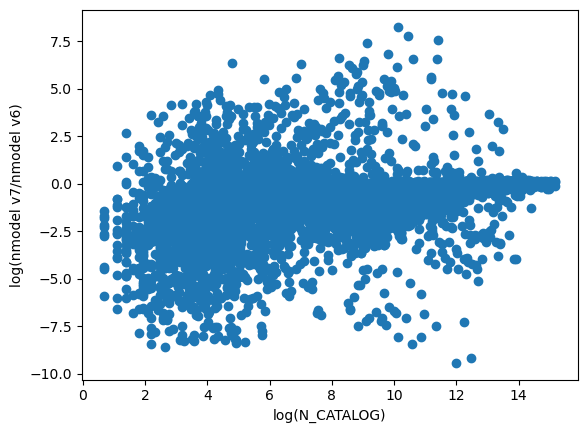

In [50]:
fig, axs = plt.subplots(1,1)
axs.set_xlabel('log(N_CATALOG)')
axs.set_ylabel('log(nmodel v7/nmodel v6)')
axs.scatter(np.log(v7['N_CATALOG'].values), np.log(rmodel))

In [76]:
mask = v7['N_CATALOG'].values/v6['N_CATALOG'].values >= 2
high_rcat = v7[mask]
mask = []
for mcid in v6['MC_SOURCE_ID']:
    mask.append(mcid in high_rcat['MC_SOURCE_ID'].values)
v6_trunc = v6[mask]
#mask2 = high_rcat['N_OBS'].values/v6_trunc['N_OBS'].values <= 0.1
high_gains = high_rcat
high_gains

,SIG,RA,DEC,MODULUS,R,N_OBS,N_OBS_HALF,N_MODEL,MC_SOURCE_ID,N_CATALOG
0,3.75,66.23,-42.53,17.67,0.03,12.0,1.0,3.56,1.0,1165
1,37.50,64.84,-41.70,20.70,0.03,195.0,84.0,1.72,2.0,2382
5,5.49,64.88,-41.60,17.46,0.28,1008.0,251.0,844.27,9.0,75086
6,32.73,64.86,-41.79,18.88,0.29,28660.0,7538.0,23471.26,10.0,1647172
7,7.81,59.38,-41.60,17.69,0.05,41.0,15.0,9.20,11.0,220
...,...,...,...,...,...,...,...,...,...,...
5740,4.39,65.94,-41.72,18.94,0.11,299.0,86.0,229.90,9995.0,135085
5741,6.08,65.68,-41.53,16.96,0.29,940.0,237.0,766.36,9996.0,20440
5742,4.32,66.18,-41.51,18.73,0.09,51.0,17.0,26.53,9997.0,119
5743,9.11,66.09,-41.43,18.61,0.29,620.0,195.0,420.50,9998.0,5256


In [77]:
# ratio of nobs - nmodel
#want to find out why we have fewer stars in nobs between v7 and v6
mask = []
for mcid in v6['MC_SOURCE_ID']:
    mask.append(mcid in high_gains['MC_SOURCE_ID'].values)
    
v6_sample = v6[mask]

mask = []
for mcid in v7['MC_SOURCE_ID']:
    mask.append(mcid in high_gains['MC_SOURCE_ID'].values)
    
v7_sample = v7[mask]

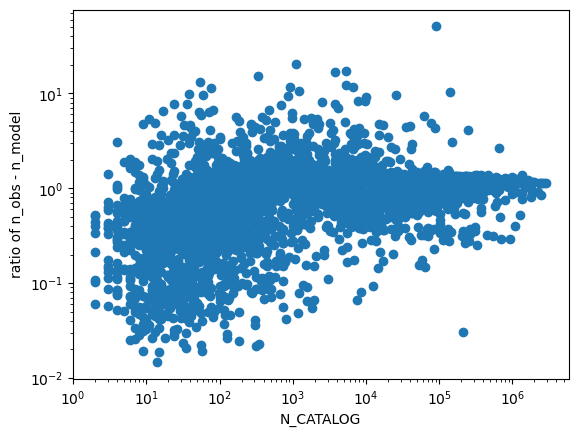

In [78]:
data = (v7_sample['N_OBS'].values-v7_sample['N_MODEL'].values)/(v6_sample['N_OBS'].values-v6_sample['N_MODEL'].values)   #ratio of excess signal objects
fig, axs = plt.subplots(1,1)
axs.set_yscale('log')
axs.set_xscale('log')

axs.set_xlabel('N_CATALOG')
axs.set_ylabel('ratio of n_obs - n_model')
axs.scatter(v7_sample['N_CATALOG'], data)
#axs.set_xlim(left=0, right=1000)

In [26]:
#setting up sim dataframe
sim_dir = '/project/shared/data/satsim/lsst_dc2_v6'
population_file = glob.glob(os.path.join(sim_dir, '*population*'))

files = glob.glob("results_dir/imperfect/*.csv")
first_file = files[0]
sim_pop = fits.read(population_file[0])
sim_pop = sim_pop.byteswap().newbyteorder() 
df1 = pd.DataFrame(sim_pop)
file_ids = [files[8:23] for files in os.listdir('results_dir/imperfect') if 'ipynb' not in files]


for i,f in enumerate(population_file):
    if i == 0:
        continue
    for ids in file_ids:
        if ids in f:
            sim_pop = fits.read(f)
            sim_pop = sim_pop.byteswap().newbyteorder()
            df2 = pd.DataFrame(sim_pop)
            df1 = pd.concat((df1,df2), ignore_index=True)
            break
            
datadf = read_csv(first_file)
for f in files:
    if f == first_file:
        continue
    df3 = pd.read_csv(f)
    datadf = pd.concat((datadf, df3), ignore_index=True)
    
mask = []
for mcid in df1['MC_SOURCE_ID'].values:
    mask.append(mcid in datadf['MC_SOURCE_ID'].values)

v6 = df1[mask]
v6 = pd.merge(v6,datadf[['MC_SOURCE_ID','SIG', 'N_MODEL','N_OBS']],on='MC_SOURCE_ID',how='left')         #merge
v6 = v6[v6['FRACDET_CORE'] == 1]
v6 = v6[v6['FRACDET_WIDE'] == 1]
v6 = v6[v6['FRACDET_HALF'] == 1]
v6 = v6[v6['EXTENSION'] <= 0.05]
v6.loc[v6.DIFFICULTY == 2, 'SIG'] = 37.5

In [27]:
#setting up sim dataframe
sim_dir = '/project/shared/data/satsim/lsst_dc2_v7'
population_file = glob.glob(os.path.join(sim_dir, '*population*'))

files = glob.glob("results_dir/perfect/*.csv")
first_file = files[0]
sim_pop = fits.read(population_file[0])
sim_pop = sim_pop.byteswap().newbyteorder() 
df1 = pd.DataFrame(sim_pop)
file_ids = [files[8:23] for files in os.listdir('results_dir/perfect') if 'ipynb' not in files]


for i,f in enumerate(population_file):
    if i == 0:
        continue
    for ids in file_ids:
        if ids in f:
            sim_pop = fits.read(f)
            sim_pop = sim_pop.byteswap().newbyteorder()
            df2 = pd.DataFrame(sim_pop)
            df1 = pd.concat((df1,df2), ignore_index=True)
            break
            
datadf = read_csv(first_file)
for f in files:
    if f == first_file:
        continue
    df3 = pd.read_csv(f)
    datadf = pd.concat((datadf, df3), ignore_index=True)
    
mask = []
for mcid in df1['MC_SOURCE_ID'].values:
    mask.append(mcid in datadf['MC_SOURCE_ID'].values)

v7 = df1[mask]
v7 = pd.merge(v7,datadf[['MC_SOURCE_ID','SIG', 'N_MODEL','N_OBS']],on='MC_SOURCE_ID',how='left')         #merge
v7 = v7[v7['FRACDET_CORE'] == 1]
v7 = v7[v7['FRACDET_WIDE'] == 1]
v7 = v7[v7['FRACDET_HALF'] == 1]
v7 = v7[v7['EXTENSION'] <= 0.05]
v7.loc[v7.DIFFICULTY == 2, 'SIG'] = 37.5

In [28]:
mask = []
for mcid in v6['MC_SOURCE_ID'].values:
    mask.append(mcid in v7['MC_SOURCE_ID'].values)

v6 = v6[mask]

In [29]:
mask = []
for mcid in v7['MC_SOURCE_ID'].values:
    mask.append(mcid in v6['MC_SOURCE_ID'].values)

v7 = v7[mask]

In [19]:
pd.set_option('display.max_columns', None)

In [21]:
sum(v7['N_MODEL'] < 1)

1243

In [33]:
print(v7_sample['MC_SOURCE_ID'].values)

[8308 8397 8251 6564 6460 6489 3864 7085 7097 4807 2524 2548 2557 9792
 4414 4012 1102 1154  338 5523 5567 5568 5569 4113 4175 7369 7456 7462
 7468 7476  439 6356 6396 3304 3355 4650 8612 5285 6817 6858 6881 2643
   16   35   94  517  561 3108 3141 7202 7212 7226 7228 7260 7269 7284
 3917 3939 6946 6999 1934 1981 9824 9870 9877 9878 9615 9623 9627 9652
 9661 9223 9262 3663 2110 2137 2140 2153 2171 4725 4736 7676 2911 2935
 2940 2995 7703 7753 7768 7780 6223 9427 9483 9489 9492 3285 5618 1379
 1395 5008 5011 5062 2223 2225 2244 2265 2066 9336 9375 1820 1824 1853
 5304 5395 4543 2809 2826 2844 2857 1534 1575 1589 6605 6644 6658 8183
 8185 4910 4917 4979 4997 7140 7153 9023 9065 2716 2753 2787 2789  254
  270  293 5769 6749 1604 8004 8005 8031 8071 2319 2415 2426 2431 2465
 2474 1434 9911 9915 9962 6171 6199 5941 5981 3519 3574 8872  128  168
  200]


In [35]:
v7_sample.loc[v7_sample['MC_SOURCE_ID'] == 2171]

,RA,DEC,DISTANCE,DISTANCE_MODULUS,STELLAR_MASS,R_PHYSICAL,N_G22,N_G24,N_CATALOG,DIFFICULTY,ABS_MAG,SURFACE_BRIGHTNESS,EXTENSION,ELLIPTICITY,POSITION_ANGLE,AGE,METAL_Z,MC_SOURCE_ID,HPIX_32,DENSITY,FRACDET_HALF,FRACDET_CORE,FRACDET_WIDE,MAGLIM_G,MAGLIM_R,EBV,SURVEY,SIG,N_MODEL,N_OBS
2852,61.221218,-43.957401,392.765869,22.970669,78199.03125,0.087528,25,298,10466,0,-7.245863,26.035477,0.013931,0.159924,77.047958,13.5,0.0001,2171,10448.0,0.000083,1.0,1.0,1.0,27.028374,26.877956,0.010414,lsst_dp0,37.5,0.13,181.0


In [32]:
#ratio ncat > 3, r_half < 0.05, ncat>10^4, ratio nobs < 0.1, check cmds, rsig ~ 1
#check nmodel for v6's as well, are they also small?

v7_sample = v7[v7['N_CATALOG'].values / v6['N_CATALOG'].values > 3]
robs = v7[v7['N_OBS'].values / v6['N_OBS'].values < 0.1]
mask = []
for mcid in v7_sample['MC_SOURCE_ID']:
    mask.append(mcid in robs['MC_SOURCE_ID'].values)
    
v7_sample[mask]
v7_sample = v7_sample[v7_sample['N_CATALOG'] > 10**4]

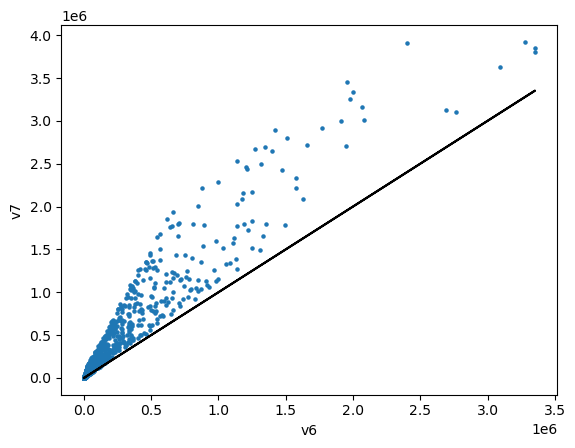

In [26]:
fig, axs = plt.subplots(1,1)

axs.set_xlabel("v6")
axs.set_ylabel("v7")
axs.scatter(simsv6['N_CATALOG'], simsv7['N_CATALOG'], s = 5)
axs.plot(simsv6['N_CATALOG'], simsv6['N_CATALOG'], color='black',)

In [40]:
len(v7['N_OBS'])

5745

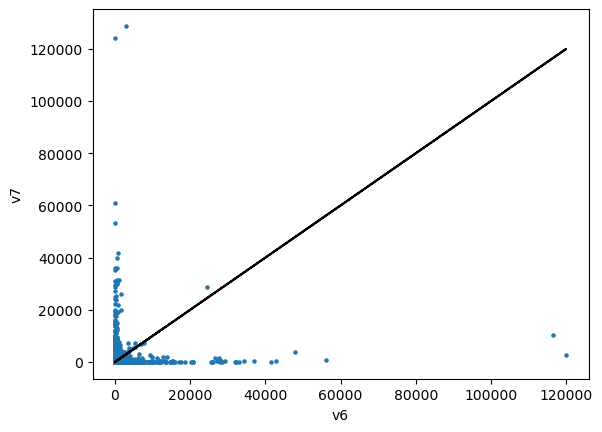

In [29]:
fig, axs = plt.subplots(1,1)

axs.set_xlabel("v6")
axs.set_ylabel("v7")
axs.scatter(v6['N_OBS'][:5000], v7['N_OBS'][:5000], s = 5)
axs.plot(v6['N_OBS'][:5000], v6['N_OBS'][:5000], color='black',)

In [ ]:
fig, axs = plt.subplots(1,1)
snrv7 = (v7['N_OBS'] - v7['N_MODEL'])/np.sqrt(v7['N_MODEL'])
axs.set_xlabel("v7[N_CATALOG]")
axs.set_ylabel("log(SNR v7)")
axs.scatter(np.log(v7['N_CATALOG']), np.log(snrv7))

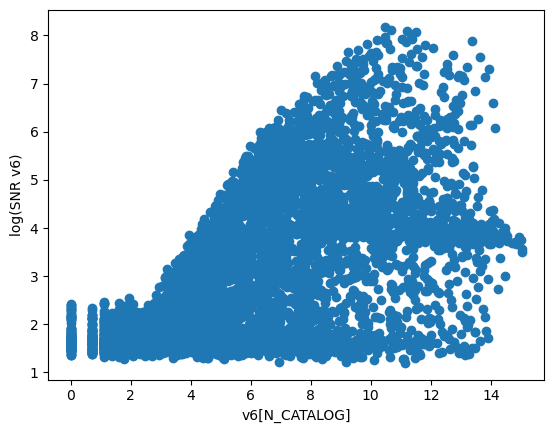

In [45]:
fig, axs = plt.subplots(1,1)
snrv6 = (v6['N_OBS'] - v6['N_MODEL'])/np.sqrt(v6['N_MODEL'])
axs.set_xlabel("v6[N_CATALOG]")
axs.set_ylabel("log(SNR v6)")
axs.scatter(np.log(v6['N_CATALOG'].values), np.log(snrv6))

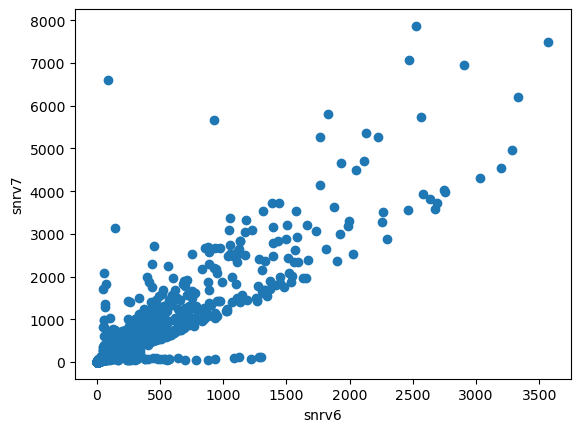

In [106]:
fig, axs = plt.subplots(1,1)
axs.set_xlabel('snrv6')
axs.set_ylabel('snrv7')
axs.scatter(snrv6, snrv7)

In [50]:
v7_sample2.columns

Index(['RA', 'DEC', 'DISTANCE', 'DISTANCE_MODULUS', 'STELLAR_MASS',
       'R_PHYSICAL', 'N_G22', 'N_G24', 'N_CATALOG', 'DIFFICULTY', 'ABS_MAG',
       'SURFACE_BRIGHTNESS', 'EXTENSION', 'ELLIPTICITY', 'POSITION_ANGLE',
       'AGE', 'METAL_Z', 'MC_SOURCE_ID', 'HPIX_32', 'DENSITY', 'FRACDET_HALF',
       'FRACDET_CORE', 'FRACDET_WIDE', 'MAGLIM_G', 'MAGLIM_R', 'EBV', 'SURVEY',
       'SIG', 'N_MODEL', 'N_OBS'],
      dtype='object')

In [59]:
sum(sel)

243

(array([14., 28., 24., 25., 28.,  6., 14., 15.,  7.,  2.,  5.,  8.,  4.,
         3.,  3.,  3.,  2.,  5.,  4.,  3.,  5.,  1.,  2.,  1.,  2.,  2.,
         1.,  3.,  1.,  0.,  0.,  1.,  0.,  0.,  2.,  2.,  1.,  0.,  1.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  1.,  0.,
         2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  3.  ,   4.95,   6.9 ,   8.85,  10.8 ,  12.75,  14.7 ,  16.65,
         18.6 ,  20.55,  22.5 ,  24.45,  26.4 ,  28.35,  30.3 ,  32.25,
         34.2 ,  36.15,  38.1 ,  40.05,  42.  ,  43.95,  45.9 ,  47.85,
         49.8 ,  51.75,  53.7 ,  55.65,  57.6 ,  59.55,  61.5 ,  63.45,
         65.4 ,  67.35,  69.3 ,  71.25,  73.2 ,  75.15,  77.1 ,  79.05,
         81.  ,  82.95,  84.9 ,  86.85,  88.8 ,  90.75,  92.7 ,  94.65,
  

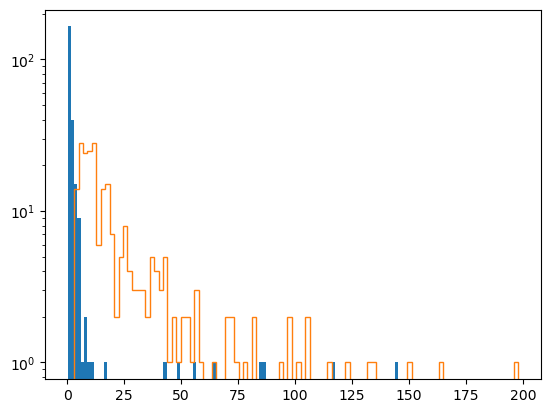

In [58]:
#nmodel for satellites with ncat < 1000
# 128<d<256, -2.5<abs_mag<2.5, log r_half<10
sel = (v7['DISTANCE'] > 128) & (v7['DISTANCE'] < 256) & (np.log10(v7['R_PHYSICAL']) < 1.5) & (v7['ABS_MAG'] > -2.5) & (v7['ABS_MAG'] < 2.5)
v7_sample2 = v7[sel]
fig, axs = plt.subplots(1,1)
axs.hist(v7_sample2['N_MODEL'], bins=100, log=True)
axs.hist(v7_sample2['N_OBS'], bins=100, log=True, histtype='step')


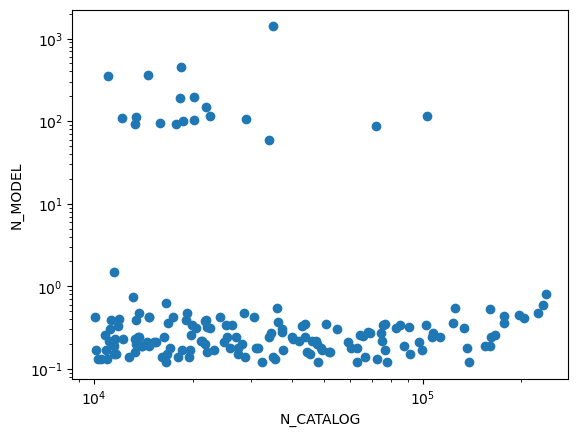

In [46]:
#ncatalog vs nmodel
fig, axs = plt.subplots(1,1)
axs.set_yscale("log")
axs.set_xscale("log")
axs.set_xlabel("N_CATALOG")
axs.set_ylabel("N_MODEL")
axs.scatter(v7_sample['N_CATALOG'].values, v7_sample["N_MODEL"].values)

(0.0, 10.0)

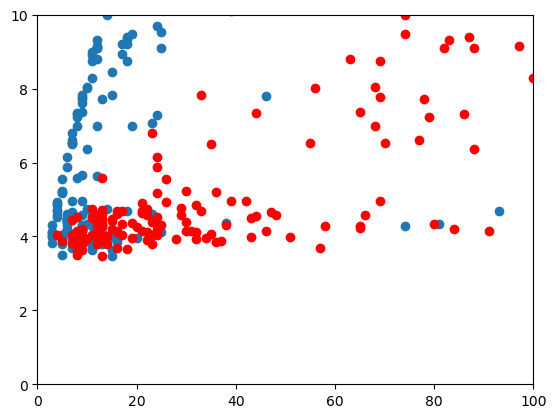

In [64]:
sel = (v7['DISTANCE'] > 128) & (v7['DISTANCE'] < 256) & (np.log10(v7['R_PHYSICAL']) < 1.5) & (v7['ABS_MAG'] > -2.5) & (v7['ABS_MAG'] < 2.5)
v7_sample2 = v7[sel]
fig, axs = plt.subplots(1,1)
axs.scatter(v7_sample2['N_OBS'],v7_sample2['SIG'])
axs.scatter(v7_sample2['N_CATALOG'],v7_sample2['SIG'], color='r')
axs.set_xlim(0,100)
axs.set_ylim(0,10)


In [ ]:
#select a satellite at edge of detectability, see if sig goes up as we reduce mag_max
#calculate s/n in different regions of cm space
#choose a satellite that is nearby but with low significance
